<a href="https://colab.research.google.com/github/flaviorv/ai_model_lifecycle/blob/tp2/tp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Feature Selection and Synthetic Data

In [48]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import numpy as np

breast_cancer = load_breast_cancer()
x = breast_cancer.data
y = breast_cancer.target

#Separating train, validation and test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42)
#Scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)
#Generating sintetic data for train
print('Train data:', len(y_train))
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)
print('With synthetic:', len(y_train))
#Adding noise
noise = np.random.normal(loc=0, scale=0.5, size=x_train.shape)
x_train = np.vstack([x_train, x_train + noise])
y_train = np.hstack([y_train, y_train])
print('With noise:', len(y_train))

#Result of the wrapper feature selector
result = {
    'recall': [],
    'features': [],
    'neighbors': [],
    'masks': {}
}

#Wrapper with different number of neighbors and features
for nk in range(10, 61, 20):
  for nf in range(5, 26, 10):
    knn = KNN(n_neighbors=nk)
    sfs = SFS(
        estimator=knn,
        n_features_to_select=nf,
        scoring='recall',
        cv=2,
        n_jobs=-1
    )

    sfs.fit(x_train, y_train)
    mask = sfs.get_support(indices=True)
    recall = cross_val_score(knn, x_val[:, mask], y_val, cv=5, scoring='recall')
    recall_mean = recall.mean()
    print(f"Recall {recall.mean():<20} Neighbors {nk:>3} Features {nf:>3}")
    result['recall'].append(recall_mean)
    result['neighbors'].append(nk)
    result['features'].append(nf)
    if nf not in result['masks']:
        result['masks'][nf] = []
    result['masks'][nf].append(mask)

Train data: 364
With synthetic: 462
With noise: 924
Recall 0.9454545454545455   Neighbors  10 Features   5
Recall 0.9818181818181818   Neighbors  10 Features  15
Recall 1.0                  Neighbors  10 Features  25
Recall 1.0                  Neighbors  30 Features   5
Recall 1.0                  Neighbors  30 Features  15
Recall 1.0                  Neighbors  30 Features  25
Recall 1.0                  Neighbors  50 Features   5
Recall 1.0                  Neighbors  50 Features  15
Recall 1.0                  Neighbors  50 Features  25


###Chart with the best combination for the best recall

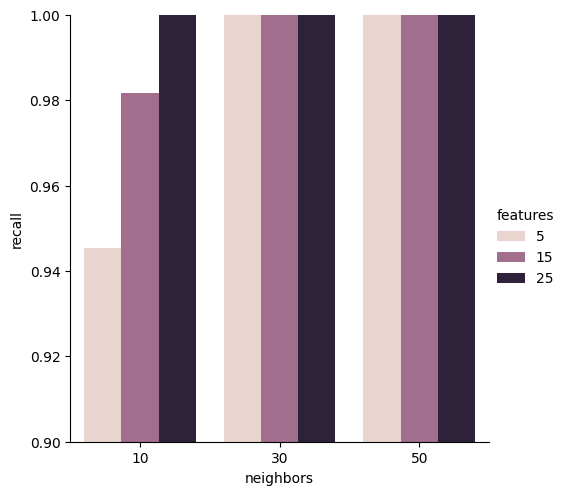

In [49]:
chart = sns.catplot(data=result, x="neighbors", y="recall", hue='features', kind='bar')
chart.set(ylim=(0.9, 1.0))

###Finding the best combination in the test

In [59]:
best_nf = 5
best_nk = [10, 30, 50]

for nk in best_nk:
  knn = KNN(n_neighbors=nk)
  for i in range(len(result['masks'][best_nf])):
    selected_features = result['masks'][best_nf][i]
    knn.fit(x_train[:, selected_features], y_train)
    y_pred = knn.predict(x_test[:, selected_features])
    recall = recall_score(y_test, y_pred)
    print(f'Neighbors {nk}')
    print(f'Features {breast_cancer.feature_names[selected_features]}')
    print('Recall', recall, '\n')

Neighbors 10
Features ['mean concave points' 'symmetry error' 'worst radius' 'worst texture'
 'worst concave points']
Recall 0.971830985915493 

Neighbors 10
Features ['mean concave points' 'worst radius' 'worst texture' 'worst perimeter'
 'worst concave points']
Recall 0.971830985915493 

Neighbors 10
Features ['mean texture' 'mean smoothness' 'worst radius' 'worst perimeter'
 'worst concave points']
Recall 0.971830985915493 

Neighbors 30
Features ['mean concave points' 'symmetry error' 'worst radius' 'worst texture'
 'worst concave points']
Recall 0.971830985915493 

Neighbors 30
Features ['mean concave points' 'worst radius' 'worst texture' 'worst perimeter'
 'worst concave points']
Recall 0.971830985915493 

Neighbors 30
Features ['mean texture' 'mean smoothness' 'worst radius' 'worst perimeter'
 'worst concave points']
Recall 0.9859154929577465 

Neighbors 50
Features ['mean concave points' 'symmetry error' 'worst radius' 'worst texture'
 'worst concave points']
Recall 0.98591549